In [89]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from config import CLAIMS_PATH, EVIDENCE_PATH, MAPPINGS_PATH, EVIDENCE_EMBEDDINGS_PATH, CLAIMS_EMBEDDINGS_PATH
from retrieve import retrieve_all, get_top_k

In [45]:
# Load Data

claims = pd.read_csv(CLAIMS_PATH)
evidences = pd.read_csv(EVIDENCE_PATH)
mappings = pd.read_csv(MAPPINGS_PATH)

vec_c = np.load(CLAIMS_EMBEDDINGS_PATH)
vec_e = np.load(EVIDENCE_EMBEDDINGS_PATH)

In [46]:
# Ground Truth

evidence_id_to_idx = {eid: idx for idx, eid in enumerate(evidences['evidence_id'])}
idx_to_claim_id = dict(enumerate(claims['claim_id']))

round_truth = defaultdict(set)
for _, row in mappings.iterrows():
    if row['label'] in ['SUPPORTS', 'REFUTES'] and row['evidence_id'] in evidence_id_to_idx:
        ground_truth[row['claim_id']].add(evidence_id_to_idx[row['evidence_id']])

ground_truth = dict(ground_truth)

In [47]:
# Eval Function

def evaluate_retrieval(vec_c, vec_e, ground_truth, idx_to_claim_id, k=10):
    retrieved = retrieve_all(vec_c, vec_e, k=k)

    results = []
    for row_idx, claim_id in idx_to_claim_id.items():
        if claim_id not in ground_truth:
            continue

        expected = ground_truth[claim_id]
        retrieved_idx = {idx for idx, _ in retrieved[row_idx]}
        hits = expected & retrieved_idx

        results.append({
            'claim_id': claim_id,
            'expected': len(expected),
            'found': len(hits),
            'recall': len(hits) / len(expected)
        })

    return pd.DataFrame(results), retrieved

In [48]:
# Recall@k

k_values = [5, 10, 20, 50, 100]
recall_scores = []

for k in k_values:
    results_df, _ = evaluate_retrieval(vec_c, vec_e, ground_truth, idx_to_claim_id, k=k)
    mean_recall = results_df['recall'].mean()
    recall_scores.append(mean_recall)
    print(f"Recall@{k:3d}: {mean_recall:.2%}")

Recall@  5: 32.92%
Recall@ 10: 42.36%
Recall@ 20: 54.08%
Recall@ 50: 68.78%
Recall@100: 78.49%


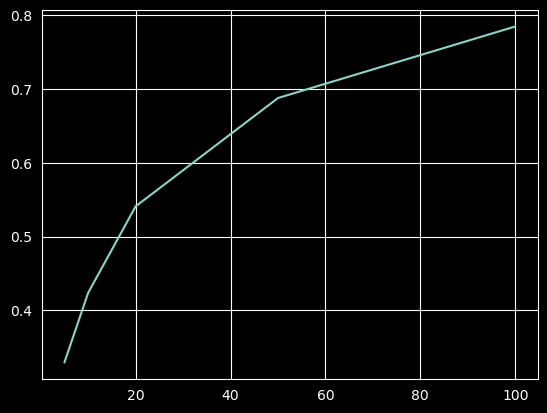

In [102]:
# Plot Recall@k

plt.plot(k_values, recall_scores)
plt.show()

In [50]:
# Results

K = 50 # Best Tradeoff with all-MiniLM-L6-v2

results_df, retrieved = evaluate_retrieval(vec_c, vec_e, ground_truth, idx_to_claim_id, k=K)

print(f"Mean Recall: {results_df['recall'].mean():.2%}")
print(f"Perfect Recall: {(results_df['recall'] == 1).sum()} / {len(results_df)}")
print(f"Zero Recall: {(results_df['recall'] == 0).sum()} / {len(results_df)}")

Mean Recall: 68.78%
Perfect Recall: 524 / 1056
Zero Recall: 161 / 1056


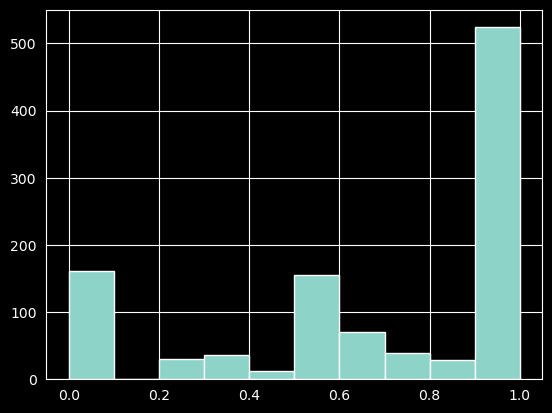

In [103]:
# Plot Distribution

plt.hist(results_df['recall'])
plt.show()

In [81]:
# Test Cases

def test_claim(claim_id, k=10, show_evidences=True):
    row_idx = claims[claims['claim_id'] == claim_id].index[0]
    claim_text = claims.iloc[row_idx]['claim']

    expected = ground_truth.get(claim_id, set())
    retrieved_idx = [idx for idx, _ in retrieved[row_idx][:k]]
    hits = set(retrieved_idx) & expected

    print(f"[{claim_id}]: {claim_text[:60]}")
    print(f"Found: {len(hits)}/{len(expected)}")
    if show_evidences:
        for idx in retrieved_idx:
            marker = "[X]" if idx in expected else "[ ]"
            print(f"{marker} {evidences.iloc[idx]['evidence'][:70]}...")
    print()

def run_tests(claim_ids, k=10, show_evidences=True):
    total_recall = []
    perfect, partial, failed = 0, 0, 0

    for cid in claim_ids:
        expected = ground_truth.get(cid, set())
        if not expected:
            continue
        row_idx = claims[claims['claim_id'] == cid].index[0]
        retrieved_idx = {idx for idx, _ in retrieved[row_idx][:k]}
        recall = len(retrieved_idx & expected) / len(expected)
        total_recall.append(recall)

        if recall == 1:
            perfect += 1
        elif recall == 0:
            failed += 1
        else:
            partial += 1

        test_claim(cid, k, show_evidences)

    print(f"{len(total_recall)}@{np.mean(total_recall):.2%}")
    print(f"{perfect}-{partial}-{failed}")

def run_random_tests(n=10, k=10, show_evidences=True):
    claim_ids = list(ground_truth.keys())
    sample = np.random.choice(claim_ids, size=min(n, len(claim_ids)), replace=False)
    run_tests(sample, k, show_evidences)

In [87]:
# Run Test

run_tests([0, 5, 6, 9, 10], 50)

[0]: Global warming is driving polar bears toward extinction
Found: 2/2
[X] Rising global temperatures, caused by the greenhouse effect, contribut...
[ ] Steven Amstrup and other U.S. Geological Survey scientists have predic...
[ ] Bear hunting caught in global warming debate....
[ ] Global warming is a major threat to global biodiversity....
[ ] The extinction risk of global warming is the risk of species becoming ...
[ ] However, in the short term, some polar bear populations in historicall...
[ ] Recently amplified arctic warming has contributed to a continual globa...
[ ] Warnings about the future of the polar bear are often contrasted with ...
[ ] One of the main theories to the extinction is climate change....
[ ] Studying the association between Earth climate and extinctions over th...
[ ] Rising temperatures cause the sea ice to melt earlier in the year, dri...
[ ] In Alaska, the effects of sea ice shrinkage have contributed to higher...
[ ] As global average temperature increa

In [86]:
# Run Random Test
run_random_tests(20, 50, False)

[2178]: Loehle and Scafetta find a 60 year cycle causing global warm
Found: 1/3

[418]: describes a world of worsening food shortages and wildfires,
Found: 3/5

[2054]: During the period 1940 to 1976 there was a cooling of the cl
Found: 1/1

[2698]: The Review concluded that CRUs actions were normal and did n
Found: 4/4

[3005]: About 60% of the warming observed from 1970 to 2000 was very
Found: 0/1

[1458]: Glaciers are retreating almost everywhere around the world ,
Found: 2/2

[2482]: The warm and cool regions roughly balance each other out wit
Found: 2/3

[1865]: Climate scientist James Hansen: we have until perhaps 50 yea
Found: 3/4

[2549]: Many people think the science of climate change is settled.
Found: 3/3

[2561]: Observed sea levels are actually tracking at the upper range
Found: 3/3

[2065]: Global warming is causing snow to disappear.
Found: 1/4

[2907]: Maximum warming occurs over the surface during winter while 
Found: 1/1

[127]: Increased atmospheric carbon dioxide ha